In [1]:
# CNN classification on CIFAR-10 dataset
# loading libraries
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization
import numpy as np

In [2]:
# checking if the device has GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# if dataset is being loaded from keras
# make sure name is the same name as the dataset in keras
def load_dataset(name):
    # load dataset
    (trainX, trainY), (testX, testY) = name.load_data()
    # shape of dataset
    train_shape, test_shape = [trainX.shape, trainY.shape], [testX.shape, testY.shape]
    num_classes = len(np.unique(trainY))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY, train_shape, test_shape

In [4]:
# if personal dataset is being used
# dataset is a dictionary with keys : train, test and values : data, labels
def dataset_personal(dataset):
    trainX, trainY, testX, testY = dataset['train']['data'], dataset['train']['labels'], dataset['test']['data'], dataset['test']['labels']
    train_shape, test_shape = [trainX.shape, trainY.shape], [testX.shape, testY.shape]
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY, train_shape, test_shape


In [5]:
# function to split dataset into train and test
def split_dataset(name, type):
    if type == 'keras':
        trainX, trainY, testX, testY, train_shape, test_shape = load_dataset(name)
    elif type == 'personal':
        trainX, trainY, testX, testY, train_shape, test_shape = dataset_personal(name)

    return trainX, trainY, testX, testY, train_shape, test_shape


In [6]:
# prepare pixel data for modeling
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [13]:
# define model architecture
def define_model(in_shape):
  with tf.device(device_name):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(in_shape, in_shape, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# plotting diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.show()

In [12]:
import matplotlib.pyplot as plt

def diagnostic_plots(history):
    # plot for loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='red', label='train')
    plt.plot(history.history['val_loss'], color='blue', label='test')
    plt.legend()
    # plot for accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='red', label='train')
    plt.plot(history.history['val_accuracy'], color='blue', label='test')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
from tqdm import tqdm
from keras.callbacks import Callback
class tqdm_cb(Callback):
    def __init__(self, total):
        super().__init__()
        self.total = total
        self.pbar = None

    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.total, desc='Training model')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(loss=logs['loss'], accuracy=logs['accuracy'])

    def on_train_end(self, logs=None):
        self.pbar.close()

def run_test_harness(dataset, type):
    # load dataset
    trainX, trainY, testX, testY, train_shape, _ = split_dataset(dataset, type)
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    x = train_shape[0][1]
    # define model
    model = define_model(x)
    history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0, callbacks=[tqdm_cb(100)])
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> Accuracy: %.3f' % (acc * 100.0))
    diagnostic_plots(history)
    # save model , install hp5py
    model.save('cnn_model.keras')

Training model: 100%|██████████| 100/100 [11:46<00:00,  7.06s/it, accuracy=0.913, loss=0.241]


> Accuracy: 82.830


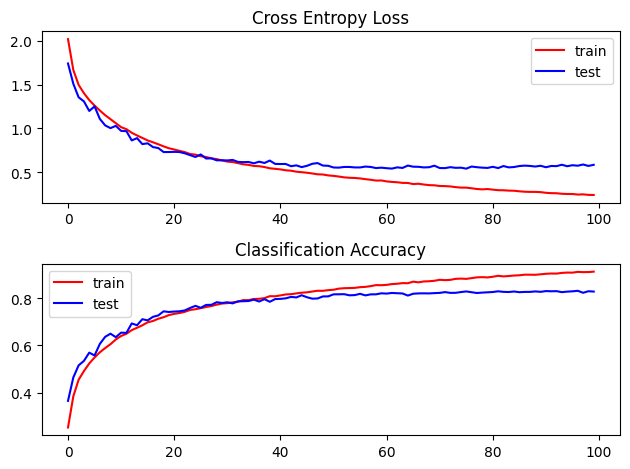

In [19]:
run_test_harness(cifar10, 'keras')